In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Importing required modules

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Approach
1. Load data
2. Find useful features
3. select useful features
4. Extract numerical and categorical columns
5. Make pipeline
6. Do Hyperparameter tuning with cross-validation
7. Check MAE
8. Find best parameters
9. Train model
10. Predict `survived` on `test_data`
11. Submit predictions

## 1. Load data

In [3]:
titanic_data = pd.read_csv("../input/titanic/train.csv", index_col="PassengerId")
test_data = pd.read_csv("../input/titanic/test.csv", index_col="PassengerId")

pd.set_option("display.max_columns", titanic_data.shape[1])
titanic_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Finding useful features

In [4]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [5]:
titanic_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<AxesSubplot:xlabel='PassengerId', ylabel='Age'>

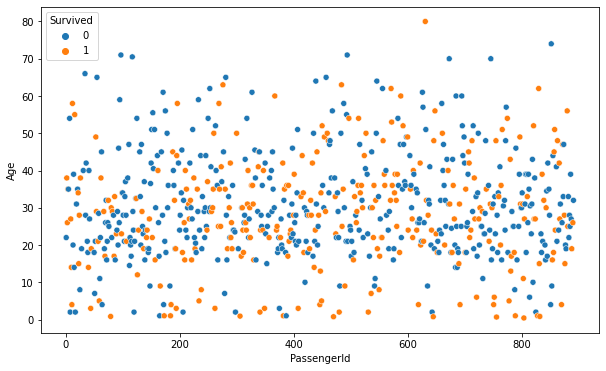

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=titanic_data.index, y="Age", hue="Survived", data=titanic_data)

<AxesSubplot:xlabel='Sex', ylabel='PassengerId'>

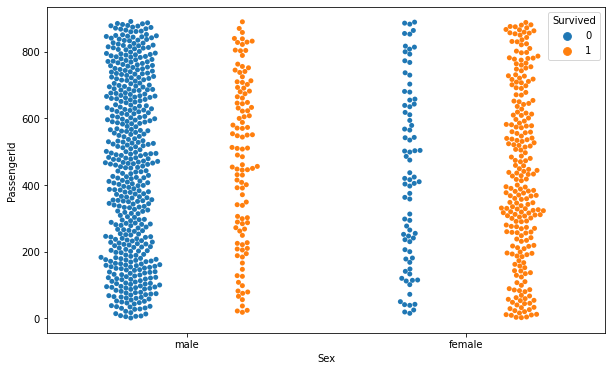

In [7]:
plt.figure(figsize=(10, 6))
sns.swarmplot(x="Sex", y=titanic_data.index, hue="Survived", data=titanic_data, dodge=True)

Looks like, more males are die, and more females have survived!

([<matplotlib.axis.XTick at 0x7f5ee444dbd0>,
 [Text(0, 0, 'Upper'), Text(1, 0, 'Middle'), Text(2, 0, 'Lower')])

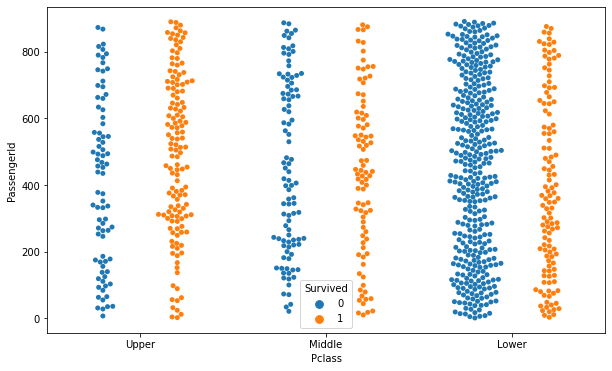

In [8]:
plt.figure(figsize=(10, 6))
sns.swarmplot(x="Pclass", y=titanic_data.index, hue="Survived", data=titanic_data, dodge=True)
plt.xticks([0, 1, 2], ["Upper", "Middle", "Lower"])

More people of Lower class (3rd class) have died

([<matplotlib.axis.XTick at 0x7f5ee43e1250>,
 [Text(0, 0, 'Southampton'),
  Text(1, 0, 'Cherbourg'),
  Text(2, 0, 'Queenstown')])

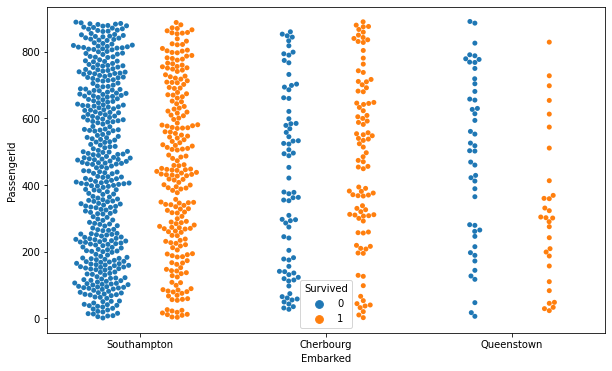

In [9]:
plt.figure(figsize=(10, 6))
sns.swarmplot(x="Embarked", y=titanic_data.index, hue="Survived", data=titanic_data, dodge=True)
plt.xticks([0, 1, 2], ["Southampton", "Cherbourg", "Queenstown"])

- S = Southampton
- C = Cherbourg
- Q = Queen

- More People boarded from `Southampton` died
- Less People die from rest both of embarked port
### But I don't think embarkation port have something related with Survived or not (according to domain knowledge)

<AxesSubplot:xlabel='Fare', ylabel='PassengerId'>

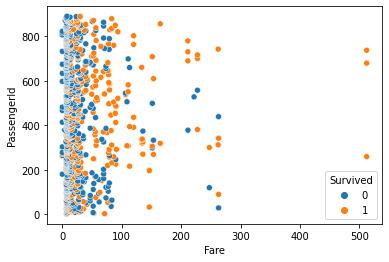

In [10]:
sns.scatterplot(x=titanic_data["Fare"], y=titanic_data.index, hue="Survived", data=titanic_data)

Removing outliers

In [11]:
outliers = titanic_data[(titanic_data["Survived"]==1) & (titanic_data["Fare"] > 400)].index
titanic_data.drop(labels=outliers, inplace=True)

<AxesSubplot:xlabel='Fare', ylabel='PassengerId'>

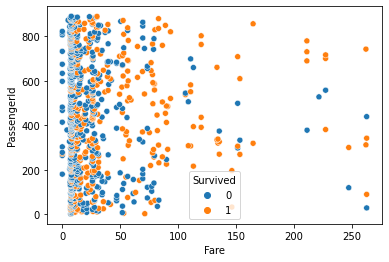

In [12]:
sns.scatterplot(x=titanic_data["Fare"], y=titanic_data.index, hue="Survived", data=titanic_data)

## 3. Selecting useful features

In [13]:
useful_features = ["Pclass", "Name", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Embarked"]
X = titanic_data[useful_features]
Y = titanic_data["Survived"]
test_data = test_data[useful_features]

## 4. Extracting numerical and categorical columns

In [14]:
num_cols = X.select_dtypes(exclude="object").columns
cat_cols = X.select_dtypes("object").columns
num_cols, cat_cols

(Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object'),
 Index(['Name', 'Sex', 'Ticket', 'Embarked'], dtype='object'))

## 5. Making Pipeline

In [15]:
class CreatePipeline:
    """Create Pipeline
    methods:
        pipeline: Create Final Pipeline
        
        create_model: Create the provided model
        
        numerical_transformer: Transform numerical cols
        
        categorical_transformer: Transform categorical cols \
        OneHotEncoding / OrdinalEncoding
        
        data_preprocessor: Preprocess the data using ColumnTransformer     
        """
    
    def pipeline(self, *, preprocessor, model, verbose=False):
        """Creates pipeline
        params:
            preprocessor
            model
        """
        steps = [("preprocessor", preprocessor),
                 ("model", model)]
        return Pipeline(steps=steps, verbose=verbose)
    
    
    def numerical_transformer(self, *, strategy="mean", **params):
        """Transform numerical columns using `SimpleImputer`.
        params:
            strategy: "mean" | "median" | "most_frequent" | "constant"
            **params: extra keyword args for SimpleImputer"""
        
        transformer = SimpleImputer(strategy=strategy, **params)
        return transformer

    
    def categorical_transformer(self, *, 
                                imp_strategy="most_frequent", 
                                encoder_type="Ordinal", 
                                imp_params={}, encoder_params={}):
        """Transform categorical columns by making Pipeline
        `SimpleImputer` | `OneHotEncoder` | `OrdinalEncoder`.
        args:
            imp_strategy: strategy for imputer values can be
                "most_frequent" | "constant"
            encoder_type: encoder type,
                "Ordinal" | "OneHot"
        kwargs:
            imp_params: keyword args for `SimpleImputer`.
            encoder_params: keyword args for encoder.`
        """
        if not encoder_type in ("Ordinal", "OneHot"):
            raise ValueError(f"Inappropriate value for encoder_type passed: {encoder_type}\
            Takes one of 'Ordinal' | 'OneHot'.")
        
        encoder = OrdinalEncoder if encoder_type=="Ordinal" else OneHotEncoder
        transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy=imp_strategy, **imp_params)),
            (encoder_type, encoder(**encoder_params))
        ])
        return transformer
    
    
    def data_preprocessor(self, *, transformers):
        """Preprocess the data using `ColumnTransformer`.
        Pass extact list of transformers
        to be passed in `ColumnTransformer`.
        each tuple consist of: (transformer_name,
                                transformer,
                                list_of_columns)."""
        preprocessor = ColumnTransformer(transformers=transformers)
        return preprocessor
    
    
    def create_model(self, *, model, random_state=0, n_estimators=1000, **kwargs):
        """Creates the model.
        **kwargs: keyword args for model."""
        my_model = model(random_state=random_state, n_estimators=n_estimators, **kwargs)
        return my_model

In [16]:
cp = CreatePipeline()
num_transformer = cp.numerical_transformer()
cat_transformer = cp.categorical_transformer(encoder_params={"handle_unknown":"use_encoded_value", "unknown_value":-1})
preprocessor = cp.data_preprocessor(
    transformers=[("num", num_transformer, num_cols),
                  ("cat", cat_transformer, cat_cols)
                 ])

## 6. Hyperparamter tuning with Cross-validation

In [17]:
n_estimators = [100, 250, 500, 750, 1000]
max_depths = [5, 10, 20]
maes = {}
i = 0
for n in n_estimators:
    for md in max_depths:
        i += 1
        model = cp.create_model(model=RandomForestClassifier, n_estimators=n, max_depth=md)
        pipeline = cp.pipeline(preprocessor=preprocessor, model=model)
        scores = -1 * cross_val_score(pipeline, X, Y, cv=10, verbose=True,
                                scoring="neg_mean_absolute_error")
        mae = scores.mean()
        maes[i] = [n, md, mae]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

## 7. Checking MAE

In [18]:
for i in maes:
    n, md, mae = maes[i]
    print(f"{i}.\tN_estimators: {n}\tMax depth: {md}\tMAE: {mae}")

1.	N_estimators: 100	Max depth: 5	MAE: 0.1845760980592441
2.	N_estimators: 100	Max depth: 10	MAE: 0.20485188968335036
3.	N_estimators: 100	Max depth: 20	MAE: 0.20375383043922374
4.	N_estimators: 250	Max depth: 5	MAE: 0.189070480081716
5.	N_estimators: 250	Max depth: 10	MAE: 0.19244126659856992
6.	N_estimators: 250	Max depth: 20	MAE: 0.1992211440245148
7.	N_estimators: 500	Max depth: 5	MAE: 0.18683605720122573
8.	N_estimators: 500	Max depth: 10	MAE: 0.19471399387129723
9.	N_estimators: 500	Max depth: 20	MAE: 0.1980720122574055
10.	N_estimators: 750	Max depth: 5	MAE: 0.18571246169560773
11.	N_estimators: 750	Max depth: 10	MAE: 0.19583758937691523
12.	N_estimators: 750	Max depth: 20	MAE: 0.2025791624106231
13.	N_estimators: 1000	Max depth: 5	MAE: 0.18458886618998976
14.	N_estimators: 1000	Max depth: 10	MAE: 0.19694841675178754
15.	N_estimators: 1000	Max depth: 20	MAE: 0.19696118488253317


In [19]:
index = min(maes, key=lambda x: maes[x][2])
maes[index]

[100, 5, 0.1845760980592441]

## 8. Finding best parameters
### `n_estimators=100` and `max_depth=5`

In [20]:
best_n_estimators = 100
best_max_depth = 5

## 9. Training Model on best parameters

In [21]:
model = cp.create_model(model=RandomForestClassifier, n_estimators=best_n_estimators, max_depth=best_max_depth)
pipeline = cp.pipeline(preprocessor=preprocessor, model=model)
pipeline.fit(X, Y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  Index(['Name', 'Sex', 'Ticket', 'Embarked'], dtype='object'))])),
                ('model', RandomForestClassifier(max_depth=5, random_state=0))])

## 10. Predicting `Survived` on `test_data`

In [22]:
test_preds = pipeline.predict(test_data)
test_preds

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,

## 11. Submitting predictions

In [23]:
output = pd.DataFrame({"PassengerId": test_data.index, "Survived": test_preds})
output.to_csv("./submission_1.csv", index=False)